In [1]:
import numpy as np
import pandas as pd
import torch
torch.set_default_tensor_type(torch.FloatTensor) 
import copy

from rct_data_generator import *
from outcome_models import *
from plotting_functions import *
from mcmc_bayes_update import *
from eig_comp_utils import *
from research_exp_utils import *
from rct_data_generator import generate_host_and_mirror


/Users/jake/Python/causal_prospective_merge/.conda/lib/python3.11/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025536958/work/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/jake/Python/causal_prospective_merge/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Simulating the data

In [2]:
rng = np.random.RandomState(42)

n_rct_before_split = 10**6
n_host = 200
sigma_prior = 1
sigma_rand_error = 1

power_x, power_x_t = 1, 1
causal_param_first_index = 4
outcome_function = lambda X, T, eps: 1 + 1 * X[:,0] - 1 * X[:,1] + 1 * X[:,2] + 4 * T + 2* X[:,0]*T + 2* X[:,1]*T + 0* X[:,2]*T + eps 
std_true_y = 1 # Standard deviation for the true Y

X0 = np.random.beta(12, 3, size= n_rct_before_split)
X1 = np.random.normal(loc=4, scale=1, size=n_rct_before_split)
X2 = np.random.beta(1, 7, size=n_rct_before_split)
x_distributions= {0: X0, 1: X1, 2:X2}

p_assigned_to_host = lambda X_0, X_1, T, eps: sigmoid(1 + 2*X_0 - X_1 + 2*T + eps)
p_assigned_to_cand2 = lambda X_0, X_1, T, eps: sigmoid(1 + 2*X_0 - X_1 + 2*T + eps)
# p_assigned_to_cand2 = lambda X_0, X_1, T, eps: sigmoid(1 - 2*X_0 + eps)

Simulation parameters

In [3]:
# Prior parameters for Bayesian update on host
prior_mean = np.array([0, 1, 0, 0, 1, 0, 0, 0])
beta_0, sigma_0_sq,inv_cov_0 = prior_mean, sigma_rand_error**2,1/sigma_prior*np.eye(len(prior_mean)) 
prior_hyperparameters = {'beta_0': beta_0, 'sigma_0_sq': sigma_0_sq,"inv_cov_0":inv_cov_0}

# Hyperparameters for Bayesian update on host
warmup_steps = 50
max_tree_depth = 5

# Number of samples used to estimate outer expectation
n_samples_for_expectation = 50
m_samples_for_expectation = 1000


# Incorporating sqrt constraint into MCMC samples
n_mc = (n_samples_for_expectation * (m_samples_for_expectation+1)) 

In [4]:
n_both_candidates_list = [200, 500, 1000]
proportion = 1 #n_cand2 = prorportion * n_both_candidates_list
std_true_y = 1


data_parameters = {'n_both_candidates_list': n_both_candidates_list, 'proportion':proportion, 'n_rct_before_split':n_rct_before_split, \
                   'x_distributions':x_distributions, 'p_assigned_to_cand2':p_assigned_to_cand2, 'n_host':n_host, 'power_x':power_x, \
                    'power_x_t':power_x_t, 'outcome_function':outcome_function, 'std_true_y':std_true_y, 'causal_param_first_index':causal_param_first_index}

### 2. EIG closed form for varying sample sizes

In [5]:
n_seeds=1
plot_additional = False

text_l1 ='p_assigned_to_host=p_assigned_to_cand2, n_samples_for_expectation = 30,'
text_l2 = 'm_samples_for_expectation = 500, n_host = 200, sigma_prior = 1, sigma_rand_error = 1,'
text_l3 = 'outcome_function = 1 + 1 * X[:,0] - 1 * X[:,1] + 1 * X[:,2] + 1 * T + 2* X[:,0]*T + 2* X[:,1]*T +2* X[:,2]*T  +eps'

In [6]:
if not plot_additional:
    dict_additional_plots_obs = dict_additional_plots_caus = {'Exact complementary':0, 'Exact twin': 0, 'Exact twin treated': 0, 'Exact twin untreated': 0}

else:
    dict_additional_plots_obs, dict_additional_plots_caus = eig_closed_form_exact_datasets(data_parameters, sigma_rand_error, prior_hyperparameters, n_mc)

EIG_obs_samples_across_seeds, EIG_caus_samples_across_seeds = [], []

for i in range (n_seeds):
    EIG_obs_closed_form, EIG_caus_closed_form = eig_closed_form_varying_sample_size(data_parameters, sigma_rand_error, prior_hyperparameters, n_mc)
    if len(EIG_obs_samples_across_seeds)==0:
        EIG_obs_samples_across_seeds= EIG_obs_closed_form
        EIG_caus_samples_across_seeds = EIG_caus_closed_form
    else:
        EIG_obs_samples_across_seeds = np.vstack((EIG_obs_samples_across_seeds, EIG_obs_closed_form))
        EIG_caus_samples_across_seeds = np.vstack((EIG_caus_samples_across_seeds, EIG_caus_closed_form))
    

For a sample size in mirror and host of 200
Percentage of treated in host: 65.6%
Percentage of treated in mirror: 33.0%
Percentage of treated in cand2: 67.0%
For a sample size in mirror and host of 500
Percentage of treated in host: 62.5%
Percentage of treated in mirror: 34.8%
Percentage of treated in cand2: 69.4%
For a sample size in mirror and host of 1000
Percentage of treated in host: 68.5%
Percentage of treated in mirror: 33.1%
Percentage of treated in cand2: 69.7%


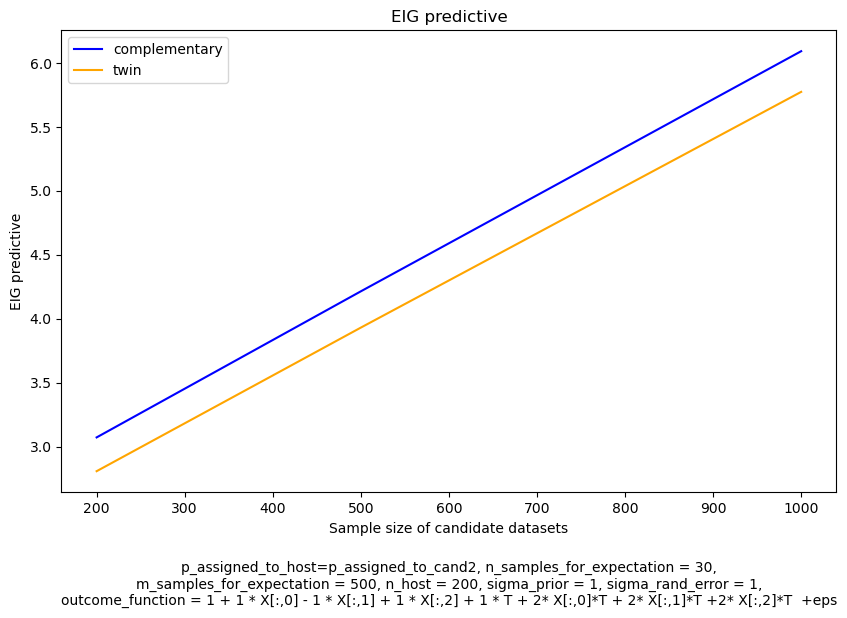

In [7]:
# path_obs_closed_form = '/Users/lucile/causal_info_gain/plots/eig_obs_closed_form'
path_obs_closed_form = 0

plot_array(dict_additional_plots_obs, n_both_candidates_list, EIG_obs_samples_across_seeds, axis_names= ['Sample size of candidate datasets', 'EIG predictive'], names=['complementary','twin'],
           text= text_l1+ '\n' + text_l2+ '\n' + text_l3, title= 'EIG predictive', save=path_obs_closed_form)

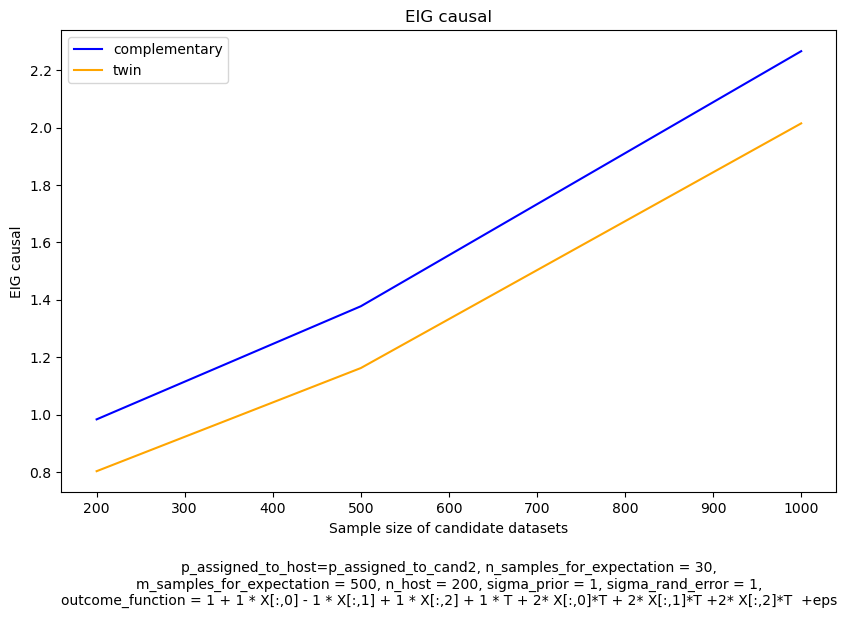

In [8]:
# path_caus_closed_form = '/Users/lucile/causal_info_gain/plots/eig_caus_closed_form'
path_caus_closed_form = 0

plot_array(dict_additional_plots_caus, n_both_candidates_list, EIG_caus_samples_across_seeds, axis_names= ['Sample size of candidate datasets', 'EIG causal'], names=['complementary','twin'],
           text= text_l1+ '\n' + text_l2+ '\n' + text_l3, title= 'EIG causal', save=path_caus_closed_form)

### 2. EIG from samples for varying sample sizes

In [9]:
n_non_causal_expectation = 40
n_samples_for_expectation = 20
m_samples_for_expectation = 80
n_causal_outer_exp = 20

# n_non_causal_expectation = 50
# n_samples_for_expectation = 20
# m_samples_for_expectation = 100
# n_causal_outer_exp = 50 total 9mins

sampling_parameters = {'n_samples_for_expectation':n_samples_for_expectation, 'm_samples_for_expectation':m_samples_for_expectation, \
                       'n_non_causal_expectation':n_non_causal_expectation, 'n_causal_outer_exp':n_causal_outer_exp}

In [10]:
n_seeds=3
EIG_obs_samples_across_seeds, EIG_caus_samples_across_seeds = [], []

for i in range (n_seeds):
    EIG_obs_samples, EIG_caus_samples = eig_from_samples_varying_sample_size(data_parameters, sigma_rand_error, prior_hyperparameters, sampling_parameters)
    if len(EIG_obs_samples_across_seeds)==0:
        EIG_obs_samples_across_seeds= EIG_obs_samples
        EIG_caus_samples_across_seeds = EIG_caus_samples
    else:
        EIG_obs_samples_across_seeds = np.vstack((EIG_obs_samples_across_seeds, EIG_obs_samples))
        EIG_caus_samples_across_seeds = np.vstack((EIG_caus_samples_across_seeds, EIG_caus_samples))

For a sample size in mirror and host of 200
Percentage of treated in host: 71.51515151515152%
Percentage of treated in mirror: 29.5%
Percentage of treated in cand2: 65.5%
pred_obs
eig_obs
pred_caus
eig_caus
For a sample size in mirror and host of 500
Percentage of treated in host: 67.0%
Percentage of treated in mirror: 33.4%
Percentage of treated in cand2: 68.6%
pred_obs
eig_obs
pred_caus
eig_caus
For a sample size in mirror and host of 1000
Percentage of treated in host: 69.5%
Percentage of treated in mirror: 37.7%
Percentage of treated in cand2: 67.5%
pred_obs
eig_obs
pred_caus
eig_caus
For a sample size in mirror and host of 200
Percentage of treated in host: 67.66917293233082%
Percentage of treated in mirror: 32.5%
Percentage of treated in cand2: 69.0%
pred_obs
eig_obs
pred_caus
eig_caus
For a sample size in mirror and host of 500
Percentage of treated in host: 69.0%
Percentage of treated in mirror: 33.4%
Percentage of treated in cand2: 71.2%
pred_obs
eig_obs
pred_caus
eig_caus
For

In [11]:
text_l1 ='p_assigned_to_host=p_assigned_to_cand2, n_samples_for_expectation = '+str(n_samples_for_expectation)
text_l2 = 'm_samples_for_expectation = '+str(m_samples_for_expectation)+', n_host = 200, sigma_prior = 1, sigma_rand_error = 1,'
text_l3 = 'outcome_function = 1 + 1 * X[:,0] - 1 * X[:,1] + 1 * X[:,2] + 1 * T + 2* X[:,0]*T + 2* X[:,1]*T +2* X[:,2]*T  +eps'
text_l4 = 'n_non_causal_expectation = '+str(n_non_causal_expectation)+', n_causal_outer_exp = '+str(n_causal_outer_exp) 

plot_additional = 0

In [12]:
plot_additional = False
if not plot_additional:
    dict_additional_plots_obs = dict_additional_plots_caus = {'Exact complementary':0, 'Exact twin': 0, 'Exact twin treated': 0, 'Exact twin untreated': 0}

else:
    dict_additional_plots_obs, dict_additional_plots_caus = eig_closed_form_exact_datasets(data_parameters, sigma_rand_error, prior_hyperparameters, n_mc)

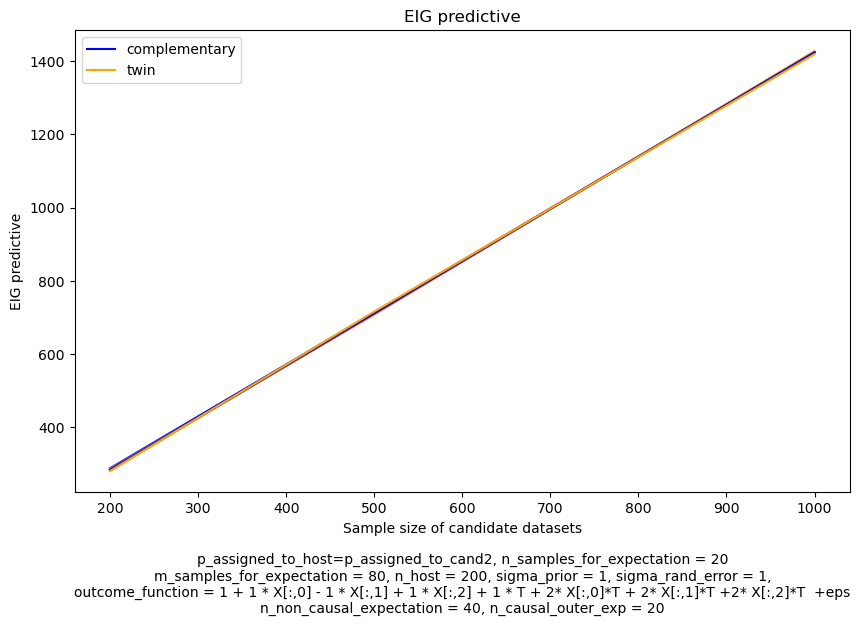

In [13]:
# path_obs_samples = '/Users/lucile/causal_info_gain/plots/eig_obs_samples'
path_obs_samples = 0

plot_array(dict_additional_plots_obs, n_both_candidates_list, EIG_obs_samples_across_seeds, axis_names= ['Sample size of candidate datasets', 'EIG predictive'], names=['complementary','twin'],
           text= text_l1+ '\n' + text_l2+ '\n' + text_l3+ '\n' + text_l4, title= 'EIG predictive', save=path_obs_samples)

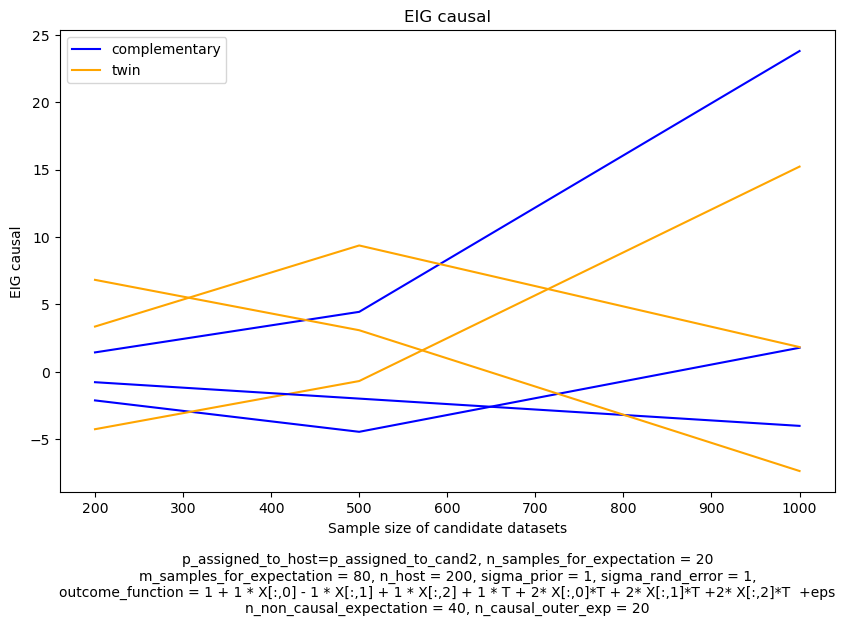

In [14]:
path_caus_samples = '/Users/lucile/causal_info_gain/plots/eig_caus_samples'
path_caus_samples = 0

plot_array(dict_additional_plots_caus, n_both_candidates_list, EIG_caus_samples_across_seeds, axis_names= ['Sample size of candidate datasets', 'EIG causal'], names=['complementary','twin'],
           text= text_l1+ '\n' + text_l2+ '\n' + text_l3+ '\n' + text_l4, title= 'EIG causal', save=path_caus_samples)